# Stock Prediction RNN 

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict Apple's stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

# Pytorch LSTM Stock Predictor

This is a Pytorch version of the original Keras LSTM Stock Predictor provided by [Super DataScience](https://www.superdatascience.com/deep-learning/), and also available elsewhere in this repo as a notebook.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [368]:
# download the data
!wget https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv

--2023-01-19 03:20:34--  https://raw.githubusercontent.com/tonylaioffer/stock-prediction-lstm-using-keras/master/data/sandp500/all_stocks_5yr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29580549 (28M) [text/plain]
Saving to: ‘all_stocks_5yr.csv.9’

all_stocks_5yr.csv. 100%[===================>]  28.21M   160MB/s    in 0.2s    

2023-01-19 03:20:34 (160 MB/s) - ‘all_stocks_5yr.csv.9’ saved [29580549/29580549]



In [369]:
!ls .

AAPL.png	      all_stocks_5yr.csv.3  all_stocks_5yr.csv.7
all_stocks_5yr.csv    all_stocks_5yr.csv.4  all_stocks_5yr.csv.8
all_stocks_5yr.csv.1  all_stocks_5yr.csv.5  all_stocks_5yr.csv.9
all_stocks_5yr.csv.2  all_stocks_5yr.csv.6  sample_data


In [370]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [371]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [372]:
import yfinance as yahooFinance


# in order to specify start date and
# end date we need datetime package
import datetime
from datetime import date

# startDate , as per our convenience we can modify
startDate = datetime.datetime(2018, 1, 1)

# endDate , as per our convenience we can modify
endDate = date.today()

#stock list
stock_list = ["AAPL","GOOG",'AMZN','TSLA']

#initialize returned data we want
stock_dict = {}

for stock in stock_list:
  
  #pass the parameters as the taken dates for start and end
  GetInformation = yahooFinance.Ticker(stock)
  stock_df = GetInformation.history(start=startDate,end=endDate)

  #Create stock_dict for future modeling and drawing plot purposes
  sub_stock_dict = {}
  sub_stock_dict['date'] = stock_df.index.values
  sub_stock_dict['value'] = stock_df.Close.values
  stock_dict[stock] = sub_stock_dict

  #Calculating the daily, monthly, and annulized volatility of the stock
  #The term “volatility” refers to the statistical measure of the dispersion of returns during a certain period of time for stocks, security, or market index. 
  #The higher the volatilty, the higher the risk of the stock.
  stock_df['daily_returns']=(stock_df['Close'].pct_change()) * 100
  daily_returns = stock_df.daily_returns.values
  daily_returns = daily_returns[~np.isnan(daily_returns)] #delete the nan
  daily_volatility = np.std(daily_returns)
  monthly_volatility = math.sqrt(21) * daily_volatility
  annualized_volatility = math.sqrt(252) * daily_volatility
  print("Daily Volatility of", stock, 'is ', str(daily_volatility), "%")
  print("Monthly Volatility of", stock, 'is ', str(monthly_volatility), "%")
  print("Annualized Volatility of", stock, 'is ', str(annualized_volatility), "%")
  print("--------------------------------")


Daily Volatility of AAPL is  2.1060730533669116 %
Monthly Volatility of AAPL is  9.651239186160643 %
Annualized Volatility of AAPL is  33.43287325285987 %
--------------------------------
Daily Volatility of GOOG is  1.9704269123078508 %
Monthly Volatility of GOOG is  9.029630477028839 %
Annualized Volatility of GOOG is  31.2795575195727 %
--------------------------------
Daily Volatility of AMZN is  2.2587015070480723 %
Monthly Volatility of AMZN is  10.350670628358623 %
Annualized Volatility of AMZN is  35.855774841456025 %
--------------------------------
Daily Volatility of TSLA is  4.137622067222746 %
Monthly Volatility of TSLA is  18.960966320167895 %
Annualized Volatility of TSLA is  65.68271405426617 %
--------------------------------


In [373]:
stock_dict

{'AAPL': {'date': array(['2018-01-02T05:00:00.000000000', '2018-01-03T05:00:00.000000000',
         '2018-01-04T05:00:00.000000000', ...,
         '2023-01-13T05:00:00.000000000', '2023-01-17T05:00:00.000000000',
         '2023-01-18T05:00:00.000000000'], dtype='datetime64[ns]'),
  'value': array([ 40.95048904,  40.94335938,  41.13354874, ..., 134.75999451,
         135.94000244, 135.21000671])},
 'GOOG': {'date': array(['2018-01-02T05:00:00.000000000', '2018-01-03T05:00:00.000000000',
         '2018-01-04T05:00:00.000000000', ...,
         '2023-01-13T05:00:00.000000000', '2023-01-17T05:00:00.000000000',
         '2023-01-18T05:00:00.000000000'], dtype='datetime64[ns]'),
  'value': array([53.25      , 54.12400055, 54.31999969, ..., 92.80000305,
         92.16000366, 91.77999878])},
 'AMZN': {'date': array(['2018-01-02T05:00:00.000000000', '2018-01-03T05:00:00.000000000',
         '2018-01-04T05:00:00.000000000', ...,
         '2023-01-13T05:00:00.000000000', '2023-01-17T05:00:00.00000

In [374]:
# Importing the training set
stock = 'GOOG'
data = pd.read_csv('./all_stocks_5yr.csv')
dataset = data[data['Name']==stock]
dataset_cl = dataset[dataset['Name']==stock].close.values

# dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# training_set = dataset_train.iloc[:, 1:2].values

In [375]:
stock_name = dataset.Name.values

In [376]:
'GOOG' in stock_name

True

In [377]:
dataset.head()

,date,open,high,low,close,volume,Name
251567,2014-03-27,568.000,568.00,552.92,558.46,13052,GOOG
251568,2014-03-28,561.200,566.43,558.67,559.99,41003,GOOG
251569,2014-03-31,566.890,567.00,556.93,556.97,10772,GOOG
251570,2014-04-01,558.710,568.45,558.71,567.16,7932,GOOG
251571,2014-04-02,565.106,604.83,562.19,567.00,146697,GOOG


## Step 1.5 calculating the daily, monthly, and annulized Volatility of the selected stock

The term “volatility” refers to the statistical measure of the dispersion of returns during a certain period of time for stocks, security, or market index. The higher the volatilty, the higher the risk of the stock.


Daily Volatility formula = √Variance --> first calculate daily return, and use the daily return dataset to calculate the its variance
         
Monthly Volatility Formula = √21 * √Variance  

Annualized Volatility Formula = √252 * √Variance

In [378]:
#calculate daily return
dataset['daily_returns']=(dataset['close'].pct_change()) * 100
dataset.head(3)

<ipython-input-378-e4722b123bff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['daily_returns']=(dataset['close'].pct_change()) * 100


,date,open,high,low,close,volume,Name,daily_returns
251567,2014-03-27,568.00,568.00,552.92,558.46,13052,GOOG,NaN
251568,2014-03-28,561.20,566.43,558.67,559.99,41003,GOOG,0.273968
251569,2014-03-31,566.89,567.00,556.93,556.97,10772,GOOG,-0.539295


In [379]:
#daily Volatility formula
daily_returns = dataset.daily_returns.values
#delete the nan
daily_returns = daily_returns[~np.isnan(daily_returns)]
#calculate the variance
daily_volatility = np.std(daily_returns)
print("Daily Volatility of", stock, 'is ', str(daily_volatility), "%")
#Monthly Volatility formula
monthly_volatility = math.sqrt(21) * daily_volatility
print("Monthly Volatility of", stock, 'is ', str(monthly_volatility), "%")
math.sqrt(252) * np.std(dataset_cl)
#Annualized Volatility formula
Annualized_volatility = math.sqrt(252) * daily_volatility
print("Annualized Volatility of", stock, 'is ', str(Annualized_volatility), "%")

Daily Volatility of GOOG is  1.4061486519595512 %
Monthly Volatility of GOOG is  6.443782635964758 %
Annualized Volatility of GOOG is  22.321917836842136 %


## normally, 

In [380]:
dataset_cl[:5] # STOCK PRICE FOR SWKS

array([558.46, 559.99, 556.97, 567.16, 567.  ])

In [381]:
len(dataset_cl) 

975

In [382]:
stock_dict_normalized[stock]['value']

array([[0.04356316],
       [0.05214037],
       [0.05406386],
       ...,
       [0.43169643],
       [0.42541564],
       [0.42168638]])

In [383]:
stock_dict_normalized['AAPL']['value']

array([[0.04528403],
       [0.04523544],
       [0.04653231],
       ...,
       [0.68496624],
       [0.69301266],
       [0.68803485]])

In [384]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1)) # X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) --> X_scaled = X_std * (max - min) + min

import copy

stock_dict_normalized = copy.deepcopy(stock_dict)

# scale the data
for stock in stock_list:
  stock_dict_normalized[stock]['value'] = stock_dict_normalized[stock]['value'].reshape(stock_dict_normalized[stock]['value'].shape[0], 1)
  stock_dict_normalized[stock]['value'] = sc.fit_transform(stock_dict_normalized[stock]['value'])

In [385]:
dataset_cl[:5] #data after scale

array([558.46, 559.99, 556.97, 567.16, 567.  ])

In [386]:
dataset_cl.shape

(975,)

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/tonylaioffer/stock-prediction-lstm-using-keras/raw/master/images/timeseries_windowing_training.gif" width=600 height=288/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [387]:
#Create a function to process the data into 7 day look back slices
def processData(data, lb):
    X, Y = [], []
    for i in range(len(data) - lb - 1):
        X.append(data[i: (i + lb), 0])
        Y.append(data[(i + lb), 0])
    return np.array(X), np.array(Y)

X_list = []
y_list = []
for stock in stock_list:
  X, y = processData(stock_dict_normalized[stock]['value'], 7) #every X: past 7 days data --> every Y: new day's data (8th day)
  print(X.shape)
  print(y.shape)
  X_list.append(X)
  y_list.append(y)


(1262, 7)
(1262,)
(1262, 7)
(1262,)
(1262, 7)
(1262,)
(1262, 7)
(1262,)


## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [388]:
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

for i in range(len(stock_list)):
  X = X_list[i]
  y = y_list[i]
  X_train, X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
  y_train, y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]

  # reshaping
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

  X_train_list.append(X_train)
  X_test_list.append(X_test)
  y_train_list.append(y_train)
  y_test_list.append(y_test)

In [389]:
# Reshaping
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

## Step 4:  Build and run an LSTM regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [390]:
class LSTM(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(LSTM, self).__init__() #This is needed to initialize the nn.Module properly
        self.num_directions = bidirectional+1
        self.rnn = nn.LSTM(
            input_size=i_size, #The number of expected features in the input x
            hidden_size=h_size, #The number of features in the hidden state h
            num_layers=n_layers, #Number of recurrent layers
            dropout=dropout,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, self.num_directions, hidden_size)
        outs = self.out(r_out)
        
        return outs, hidden_state

In [391]:
# Globals

INPUT_SIZE = 7
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 1
BATCH_SIZE = 128
# Hyper parameters

learning_rate = 0.001
num_epochs = 300

rnn = LSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE,bidirectional=False)
#rnn.cuda() #to set up and run CUDA operations. It keeps track of the currently selected GPU
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

hidden_state = None

In [392]:
rnn

LSTM(
  (rnn): LSTM(7, 64, num_layers=3, dropout=0.1)
  (out): Linear(in_features=64, out_features=1, bias=True)
)

In [393]:
"""
class StockDataset(Dataset):
    
    def __init__(self, X_dataset, Y_dataset):
        
        self.X_dataset = torch.from_numpy(X_dataset)
        self.Y_dataset = torch.from_numpy(Y_dataset)
        
    def __len__(self):
        return np.shape(self.Y_dataset)[0]

    def __getitem__(self, idx):
        
        sample = {'Sequence': self.X_dataset[:,idx,:], "Target": self.Y_dataset[idx]}
      

        return sample
"""

'\nclass StockDataset(Dataset):\n    \n    def __init__(self, X_dataset, Y_dataset):\n        \n        self.X_dataset = torch.from_numpy(X_dataset)\n        self.Y_dataset = torch.from_numpy(Y_dataset)\n        \n    def __len__(self):\n        return np.shape(self.Y_dataset)[0]\n\n    def __getitem__(self, idx):\n        \n        sample = {\'Sequence\': self.X_dataset[:,idx,:], "Target": self.Y_dataset[idx]}\n      \n\n        return sample\n'

In [394]:
# Train_ds=StockDataset(X_train, y_train)

In [395]:

history = []
X_test_cuda = torch.tensor(X_test_list[3]).float()#.cuda()
y_test_cuda = torch.tensor(y_test_list[3]).float()#.cuda()

# we use all the data in one batch
inputs_cuda = torch.tensor(X_train_list[3]).float()#.cuda()
labels_cuda = torch.tensor(y_train_list[3]).float()#.cuda()

for epoch in range(num_epochs):
    rnn.train()
    output, _ = rnn(inputs_cuda, hidden_state) 
    # print(output.size())

    loss = criterion(output[:,0,:].view(-1), labels_cuda)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)                    # back propagation
    optimiser.step()                    # update the parameters
    
    if epoch % 20 == 0:
        rnn.eval()
        test_output, _ = rnn(X_test_cuda, hidden_state)
        test_loss = criterion(test_output.view(-1), y_test_cuda)
        print('epoch {}, loss {}, eval loss {}'.format(epoch, loss.item(), test_loss.item()))
    else:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
    history.append(loss.item())

# train_inputs = torch.tensor(X_train).float().cuda()
train_pred, hidden_state = rnn(inputs_cuda, None)
train_pred_cpu = train_pred.cpu().detach().numpy()
train_prediction = train_pred_cpu.reshape(-1,1)


# use hidden state from previous training data
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()
test_prediction = test_predict_cpu.reshape(-1,1)


epoch 0, loss 0.12021215260028839, eval loss 0.34818559885025024
epoch 1, loss 0.10830539464950562
epoch 2, loss 0.09838201850652695
epoch 3, loss 0.08986063301563263
epoch 4, loss 0.08225356787443161
epoch 5, loss 0.0757393091917038
epoch 6, loss 0.06974738836288452
epoch 7, loss 0.06546077877283096
epoch 8, loss 0.0621848963201046
epoch 9, loss 0.06093747168779373
epoch 10, loss 0.06006726622581482
epoch 11, loss 0.058143217116594315
epoch 12, loss 0.05405295640230179
epoch 13, loss 0.048924971371889114
epoch 14, loss 0.041781745851039886
epoch 15, loss 0.033926673233509064
epoch 16, loss 0.026504669338464737
epoch 17, loss 0.01927441731095314
epoch 18, loss 0.01303053181618452
epoch 19, loss 0.008891286328434944
epoch 20, loss 0.007423102390021086, eval loss 0.02683405578136444
epoch 21, loss 0.0052963183261454105
epoch 22, loss 0.004811803810298443
epoch 23, loss 0.005852796602994204
epoch 24, loss 0.006600580178201199
epoch 25, loss 0.0062015182338654995
epoch 26, loss 0.006559808

In [396]:
train_prediction.shape

(1009, 1)

In [397]:
test_prediction.shape

(253, 1)

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

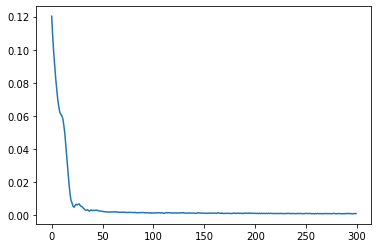

In [398]:
plt.plot(history)
# dplt.plot(history.history['val_loss'])

In [399]:
X_test[0]

array([[0.93273682, 0.88125944, 0.86164659, 0.83004165, 0.85613625,
        0.86139534, 0.89641707]])

In [400]:
# X_train_X_test = np.concatenate((X_train, X_test),axis=0)
# hidden_state = None
rnn.eval()
# test_inputs = torch.tensor(X_test).float().cuda()
test_predict, _ = rnn(X_test_cuda, hidden_state)
test_predict_cpu = test_predict.cpu().detach().numpy()

In [401]:
test_predict_cpu.shape

(253, 1, 1)

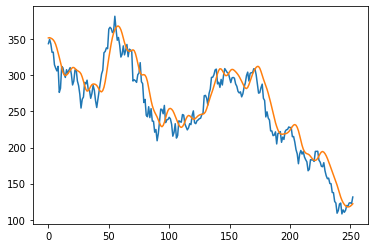

In [402]:
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)))
plt.plot(sc.inverse_transform(test_predict_cpu.reshape(-1,1)))

In [403]:
split_pt = int(X_list[0].shape[0] * 0.80) + 7
split_pt

1016

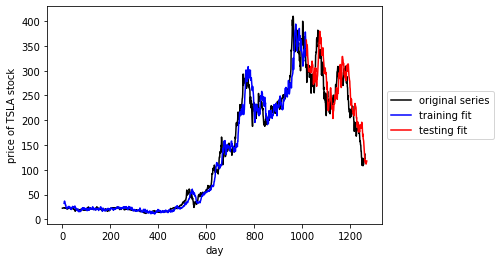

In [404]:
# plot original data
plt.plot(sc.inverse_transform(y.reshape(-1,1)), color='k')

# # train_inputs = torch.tensor(X_train).float().cuda()
# train_pred, hidden_state = rnn(inputs_cuda, None)
# train_pred_cpu = train_pred.cpu().detach().numpy()

# # use hidden state from previous training data
# test_predict, _ = rnn(X_test_cuda, hidden_state)
# test_predict_cpu = test_predict.cpu().detach().numpy()

# plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
split_pt = int(X_list[0].shape[0] * 0.80) + 7 # window_size
plt.plot(np.arange(7, split_pt, 1), sc.inverse_transform(train_prediction), color='b')
plt.plot(np.arange(split_pt, split_pt + len(test_predict_cpu), 1), sc.inverse_transform(test_prediction), color='r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('price of TSLA stock')
plt.legend(['original series','training fit','testing fit'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [405]:
from sklearn.metrics import mean_squared_error

train_prediction = train_pred_cpu.reshape(-1,1)
test_prediction = test_predict_cpu.reshape(-1,1)
print('Stock TSLA:')
print("The MSE for training data is " + str(mean_squared_error(train_prediction,y_train)))
print("The MSE for testing data is " + str(mean_squared_error(test_prediction,y_test)))

Stock TSLA:
The MSE for training data is 0.0008728720345798156
The MSE for testing data is 0.002600343577032937
